# Simulation du système solaire par Störmer Verlet sous l'effet des forces gravitationnelles uniquement

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import numpy as np
from numpy.linalg import norm

In [3]:
%matplotlib inline

In [12]:
width = 10
height = width / 1.618
label_size = 12
font_size = 15
title_size = 19

preamble = [
        r"\usepackage[utf8x]{inputenc}",
        r"\usepackage[T1]{fontenc}"
]

plt.rc('pgf', texsystem='pdflatex', preamble=preamble)
plt.rc('figure', figsize=[width, height], autolayout=True)
plt.rc('font', size=font_size, family='Serif')
plt.rc('text', usetex=True)
plt.rc('lines', linewidth=1.2)

plt.rc('axes.spines', top=False, right=False)
plt.rc('axes', labelsize=19, grid=False, titlesize=title_size, titlepad=22)
plt.rc('axes3d', grid=False)

## Définition des données

In [4]:
# On définit les coprs et chacun avec son indice 
liste_corps = ['Soleil', 'Jupiter', 'Saturne', 'Uranus', 'Neptune', 'Pluton']
ncorps = len(liste_corps)

# On définit la constante gravitationnelle:
G = 2.95912208286E-4

# On définit les masses de chaque corps
masses = np.array([
    1.00000597682,
    0.000954786104043,
    0.000285583733151,
    0.0000437273164546,
    0.0000517759138449,
    0.00000000769230769230769
])

# On définit les positions de chaque corps dans un repère à 3d (x, y, z)
positions = np.array([
    [0, 0, 0],
    [2.2911898857058, 4.4742096428394, -0.0698526085811],
    [-8.4077274422046, -4.9386528867475, 0.4206194745212],
    [19.9506411858858, -2.1189594536568, -0.2505524004432],
    [26.3841113101207, -14.2637141476417, -0.3141826415529],
    [4.7240342661351, -31.8776619468451, 2.0454833905119]
])

# On définit les vitesses de chaque corps dans un repère à 3d (x, y, z)
vitesses = np.array([
    [0, 0, 0],
    [-0.0068140485228, 0.0038022184356, 0.0001366932116],
    [0.0025181864149, -0.0048203311629, -0.0000164411567],
    [-0.0004495229028, 0.0037304364206, 0.0000197241717],
    [0.0014665671695, 0.0027825194375, -0.0000910521187],
    [0.0031588952992, -0.0001620298531, -0.0008976519916]
])

# Mise en place de la méthode de Störmer-Verlet

## Le modèle

$$
\forall i \in \big\{1,\ldots,6\big\}  \begin{cases}
      \displaystyle
      v_{i}^{n+\frac{1}{2}} = v_{i}^{n} - \frac{1}{2}*h * G * 
      \sum_{j=1\\j\ne i}^{6}{\frac{q_{i}^{n}-q_{j}^{n}}{\left\lVert q_{i}^{n}-q_{j}^{n}\right\rVert ^3}}\\
      q_{i}^{n+1} = q_{i}^{n} + h * v_{i}^{n+\frac{1}{2}}\\
      \displaystyle
      v_{i}^{n+1} = v_{i}^{n+\frac{1}{2}} - \frac{1}{2} * h * G * 
      \sum_{j=1\\j\ne i}^{6}{\frac{q_{i}^{n+1}-q_{j}^{n+1}}{\left\lVert q_{i}^{n+1}-q_{j}^{n+1}\right\rVert ^3}}\\
   \end{cases} 
$$

## L'implémentation

In [5]:
def solar_sim_stormer_verlet(dt, N):
    N = N // dt 
    # on crée les matrices des solutions pour les vitesses et les positions
    q = np.zeros([N+1, ncorps, 3])
    v = np.zeros([N+1, ncorps, 3])
    
    # on met en place les conditions initiales
    for i in range(ncorps):
        q[0, i, :] = positions[i]
        v[0, i, :] = vitesses[i]

    corps = set(range(ncorps))
    
    for n in range(N):
        v05 = np.zeros([ncorps, 3])
        for i in corps:
            total = np.zeros(3)
            for j in corps.difference([i]):
                qij = q[n, i, :] - q[n, j, :]
                d3 = (norm(qij))**3
                total = total + masses[j] * qij / d3
            total = - G * total
            v05[i]  = v[n, i, :] + .5 * dt * total
            q[n+1, i, :] = q[n, i, :] + dt * v05[i]

        for i in corps:
            total = np.zeros(3)
            for j in corps.difference([i]):
                qij = q[n+1, i, :] - q[n+1, j, :]
                d3 = (norm(qij))**3
                total = total + masses[j] * qij / d3
            total = - G * total
            
            v[n+1, i, :] = v05[i] + .5 * dt  * total

    # Variables pour le hamiltonien
    
    H = np.zeros(N+1)
    for n in range(N+1):
        sum1 = 0
        sum2 = 0
        for i in range(ncorps):
            sum1 += masses[i]*norm(v[n, i])**2
        for i in range(ncorps-1):
            for j in range(i+1, ncorps):
                d = norm(q[n, i, :] - q[n, j, :])
                sum2 = sum2 + masses[i] * masses[j] / d
        H[n] =  .5 * sum1 - G * sum2
    
    return [v, q, H]

## Tracé de  l’évolution de l’énergie et les trajectoires obtenues avec le schéma de Störmer-Verlet pour un pas de temps de 10 jours et une durée de simulation de 200 000 jours puis un pas de temps de 200 jours.

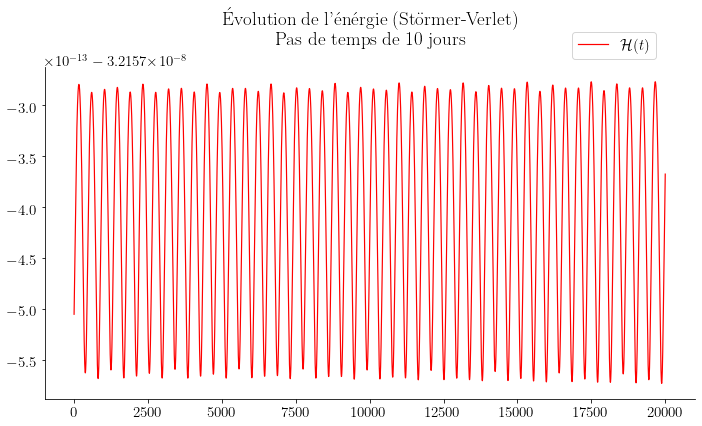

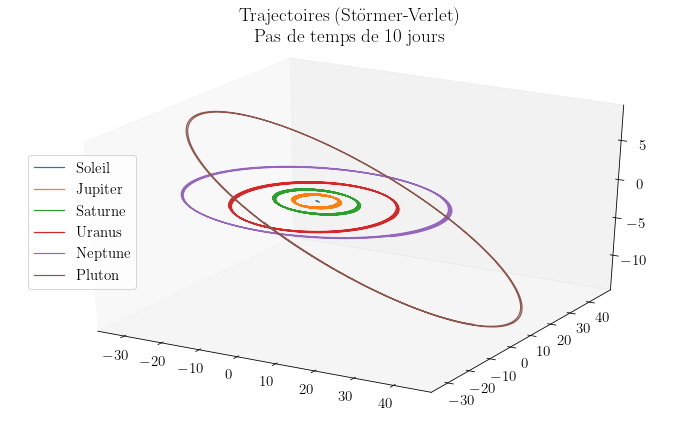

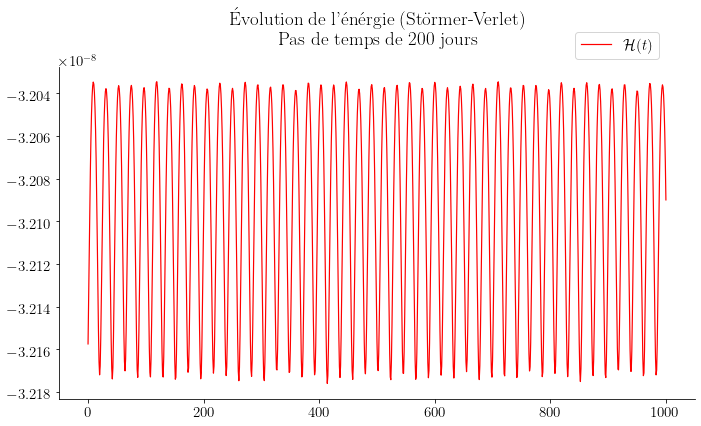

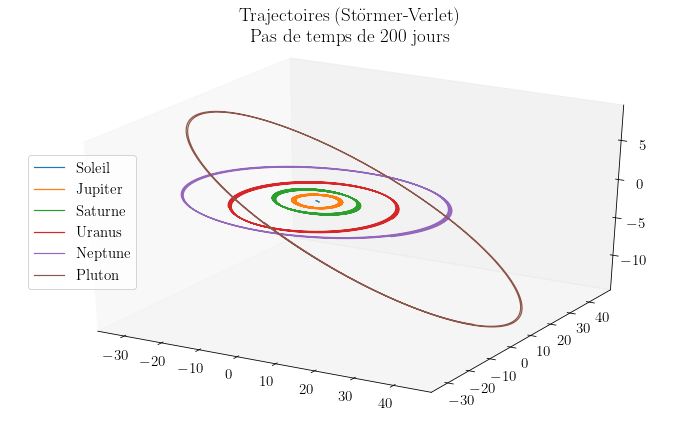

In [13]:
N = 200000

for dt in [10, 200]:
    vs, qs, Hs = solar_sim_stormer_verlet(dt, N)
    _, ax1  = plt.subplots();
    _, ax2 = plt.subplots(subplot_kw=dict(projection='3d'));
    ax1.set_title(f'Évolution de l\'énérgie (Störmer-Verlet)\nPas de temps de {dt} jours')
    ax2.set_title(f'Trajectoires (Störmer-Verlet)\nPas de temps de {dt} jours')
    ax1.plot(Hs, label='$\mathcal{H}(t)$', c='r');

    for i in range(6):
        ax2.plot(qs[:,i, 0], qs[:,i, 1], qs[:,i, 2], label = liste_corps[i]);

    ax1.legend(bbox_to_anchor=[0.8, 1])
    ax2.legend(bbox_to_anchor=[0.2, 0.7]);

## Période de révolution de Neptune et Pluton autour du soleil une approche grossière.

### Période de révolution de Neptune autour du soleil

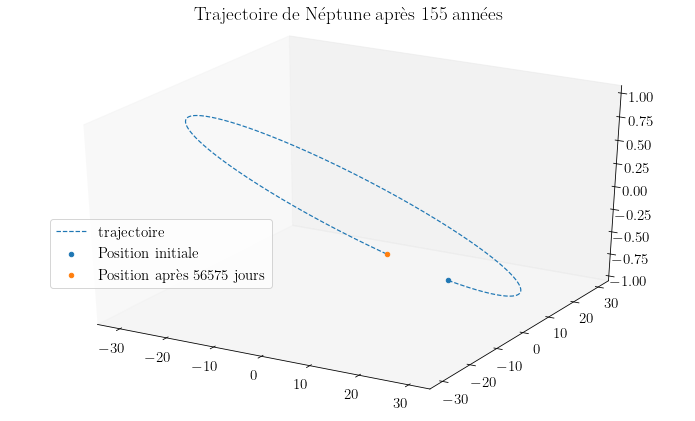

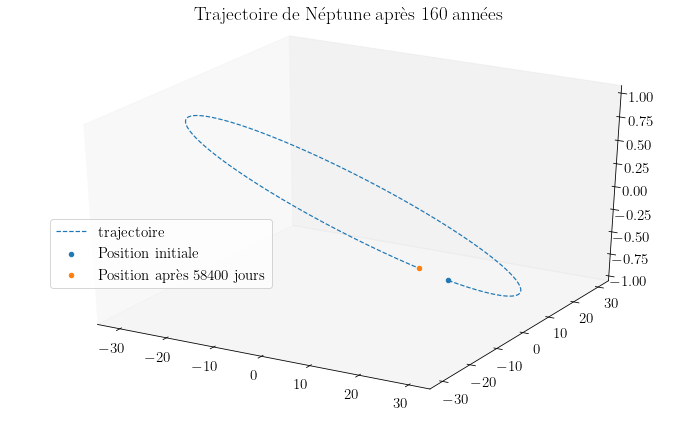

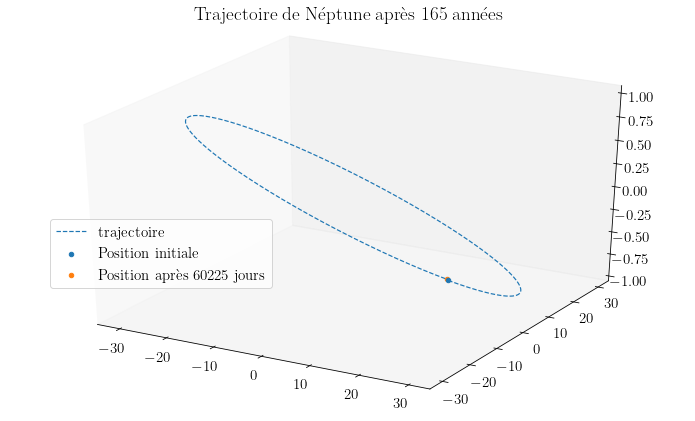

In [14]:
dt = 50
N = 365
for i in range(155, 169, 5):
    x = N * i
    v, q, H = solar_sim_stormer_verlet(dt, x)
    _, ax = plt.subplots(subplot_kw=dict(projection='3d'));
    ax.scatter(q[0,4, 0], q[0,4, 1], q[0,4, 2], label='Position initiale')
    ax.plot(q[:,4, 0], q[:,4, 1], q[:,4, 2], '--', label='trajectoire')
    ax.scatter(q[-1, 4, 0], q[-1, 4, 1], q[-1, 4, 2], label=f'Position après {x} jours')
    ax.set_title(f'Trajectoire de Néptune après {i} années')
    ax.legend(bbox_to_anchor=[.4, .5])

 **<span style="color:blue">La période de révolution de Neptune autour du soleil est environ 165 ans</span>**

### Période de révolution de Pluton autour du soleil.

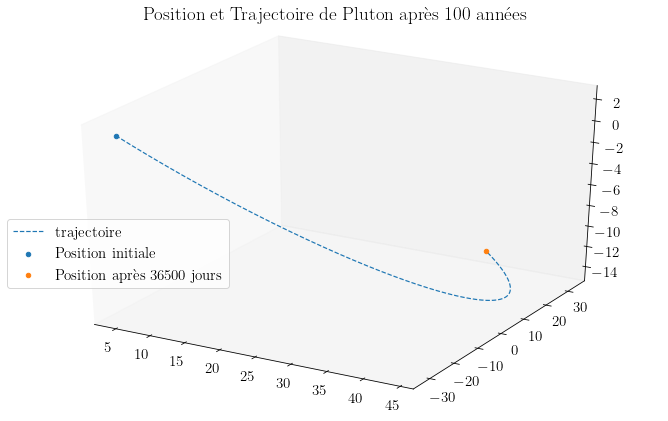

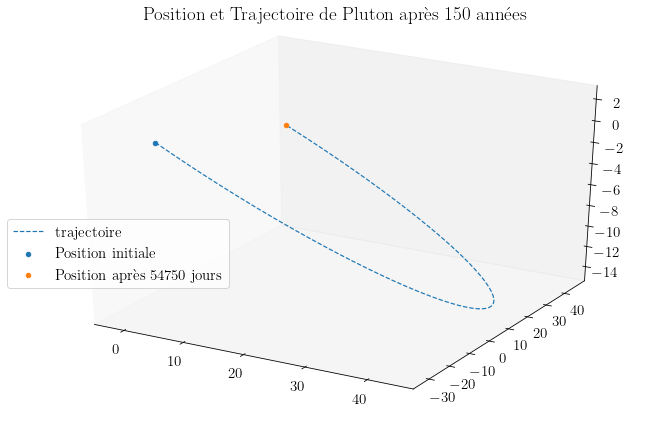

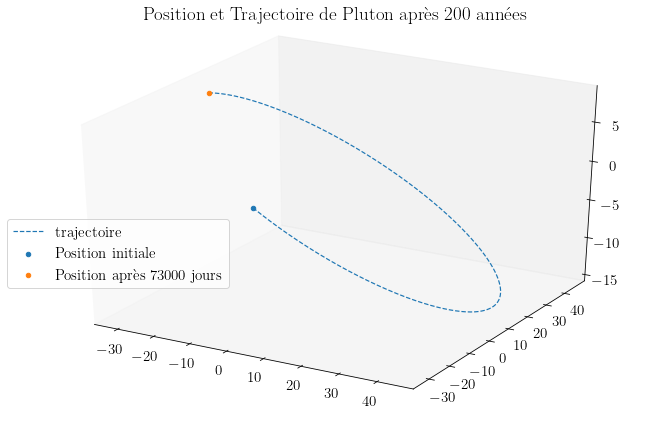

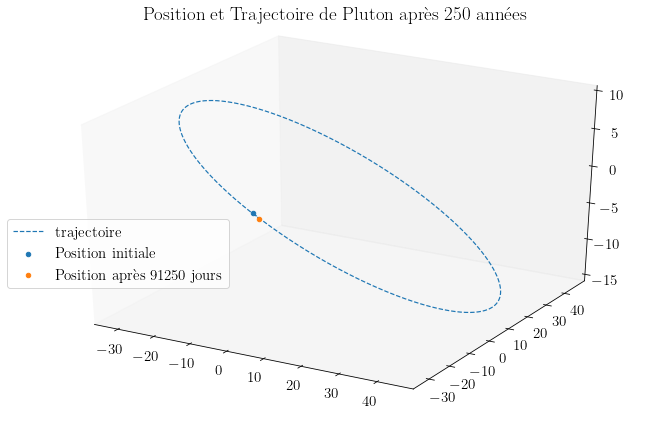

In [15]:
dt = 100
N = 365
for i in range(100, 256, 50):
    x = N * i
    v, q, H = solar_sim_stormer_verlet(dt, x)
    _, ax = plt.subplots(subplot_kw=dict(projection='3d'));
    ax.scatter(q[0, 5, 0], q[0, 5, 1], q[0, 5, 2], label='Position initiale')
    ax.plot(q[:, 5, 0], q[:, 5, 1], q[:, 5, 2], '--', label='trajectoire')
    ax.scatter(q[-1, 5, 0], q[-1, 5, 1], q[-1, 5, 2], label=f'Position après {x} jours')
    ax.set_title(f'Position et Trajectoire de Pluton après {i} années')
    ax.legend(bbox_to_anchor=[.35, .5])

 **<span style="color:blue">La période de révolution de Pluton autour du soleil est environ 250 ans</span>**

# Représentation de la solution numérique sous forme d'animation

In [9]:
def solaire_anime(N,dt):
    N = N // dt 
    q = np.zeros([N+1, 6, 3])
    v = np.zeros([N+1, 6, 3])
    for i in range(6):
        q[0, i, :] = positions[i]
        v[0, i, :] = vitesses[i]
    corps = set(range(6))
    fig = plt.figure(figsize=[10, 6.18])
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim3d([-40.,40.])
    ax.set_ylim3d([-40.,40.])
    ax.set_zlim3d([-20.,20.])
    lines = []
    pts = []
    colors = ["#FFB265", "#d11141", "#00b159", "#00aedb", "#f37735", "#6f7c85"]

    for i in range(6):
        lines += ax.plot([], [], [],'--', color=colors[i] )
        pts += ax.plot([], [], [], 
                       marker=f'${liste_corps[i][0:3]}$',
                       color=colors[i], 
                       markersize=30)

    for n in range(N):
        v05 = np.zeros([6, 3])
        for i in corps:
            total = np.zeros(3)
            for j in corps.difference([i]):
                qij = q[n, i, :] - q[n, j, :]
                d3 = (norm(qij))**3
                total = total + masses[j] * qij / d3
            total = - G * total
            v05[i]  = v[n, i, :] + .5 * dt * total
            q[n+1, i, :] = q[n, i, :] + dt * v05[i]

        for i in corps:
            total = np.zeros(3)
            for j in corps.difference([i]):
                qij = q[n+1, i, :] - q[n+1, j, :]
                d3 = (norm(qij))**3
                total = total + masses[j] * qij / d3
            total = - G * total

            v[n+1, i, :] = v05[i] + .5 * dt  * total

        x = q[:, :, 0]
        y = q[:, :, 1]
        z = q[:, :, 2]
        for pt,line,i in zip(pts,lines,range(6)):
            line.set_data(x[:n, i],y[:n, i])
            line.set_3d_properties(z[:n, i])
            pt.set_data(q[n, i,0],q[n, i,1])
            pt.set_3d_properties(q[n, i,2])


        plt.pause(0.0001)

In [10]:
%matplotlib qt 

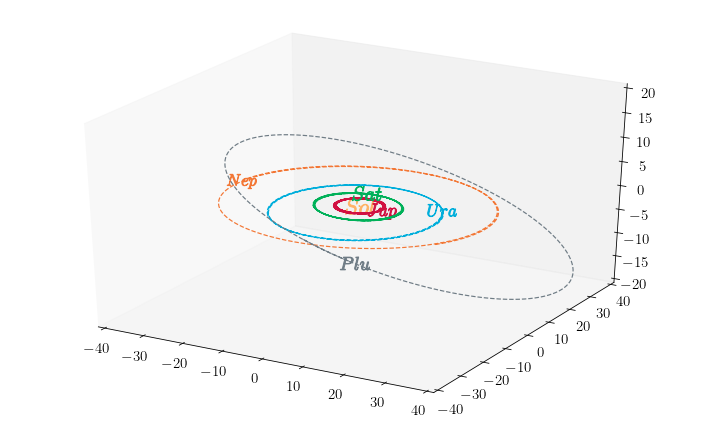

In [16]:
solaire_anime(365*260,250)